In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams["text.latex.preamble"] = r"\usepackage{newtxtext,newtxmath}"
mpl.rcParams["font.size"] = 12
%matplotlib inline

import jax.numpy as jnp
from jax import random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC
numpyro.set_host_device_count(10)

import arviz as az
import seaborn as sns
import daft
from corner import corner

rng = random.PRNGKey(2023)

Suppose we have a cluster of $N$ stars each with distance $d_i$. The cluster will have a mean distance and spread $\mu_d$, $\sigma_d$. We also have apparent magnitudes $m_i$. This is a simplified version of Leistedt and Hogg (2017).

In [2]:
rng, *key = random.split(rng, 5)

num_obs = 20
mu_d = 10
sigma_d = 0.1

shape = (num_obs,)

d = mu_d + sigma_d * random.normal(key[0], shape=shape)
abs_mag = random.normal(key[1], shape=shape)
mag = abs_mag + 5 * np.log10(d)
par = 1 / d

sigma_mag = 0.1
sigma_par = 0.01

mag_obs = mag + sigma_mag * random.normal(key[2], shape=shape)
par_obs = par + sigma_par * random.normal(key[3], shape=shape)

In [130]:
star = np.arange(num_obs)
table = pd.DataFrame(
    dict(d=d, abs_mag=abs_mag, par=par, mag=mag, par_obs=par_obs, mag_obs=mag_obs),
    index=star
)
table.index.name = "Star"
table.to_csv("data/hbm-inputs.csv")
table.head()

,d,abs_mag,par,mag,par_obs,mag_obs
Star,,,,,,
0,9.959026,-1.275786,0.100411,3.715298,0.094393,3.562791
1,10.173046,0.309822,0.098299,5.347077,0.092023,5.352257
2,10.120465,-0.684417,0.098810,4.341586,0.105925,4.364776
3,9.895651,0.753958,0.101054,5.731180,0.115520,5.987240
4,10.102282,0.700781,0.098988,5.722878,0.096356,5.645176


In [132]:
pd.read_csv("data/hbm-inputs.csv", index_col=0).head()

,d,abs_mag,par,mag,par_obs,mag_obs
Star,,,,,,
0,9.959026,-1.275786,0.100411,3.715298,0.094393,3.562791
1,10.173046,0.309822,0.098299,5.347077,0.092023,5.352257
2,10.120465,-0.684417,0.098810,4.341586,0.105925,4.364776
3,9.895651,0.753958,0.101055,5.731180,0.115520,5.987240
4,10.102282,0.700781,0.098988,5.722878,0.096356,5.645176


In [136]:
columns = {
    "d": r"$d_\mathrm{true}$",
    "abs_mag": r"$\mathrm{V_{true}}$",
    "par": r"$\varpi_\mathrm{true}$", 
    "mag": r"$\mathrm{v_{true}}$",
    "par_obs": r"$\varpi_\mathrm{obs}$", 
    "mag_obs": r"$\mathrm{v_{obs}}$",
}
stable = table.rename(columns=columns).style.format(
    {r"$\varpi_\mathrm{"+i+"}$": "{:.5f}" for i in ["true", "obs"]}, 
    precision=4
)
stable.to_latex(
    "../tables/hbm-data.tex",
    column_format="r|rrrr|rr",
    hrules=True,
)
stable

,$d_\mathrm{true}$,$\mathrm{V_{true}}$,$\varpi_\mathrm{true}$,$\mathrm{v_{true}}$,$\varpi_\mathrm{obs}$,$\mathrm{v_{obs}}$
Star,,,,,,
0,9.9590,-1.2758,0.10041,3.7153,0.09439,3.5628
1,10.1730,0.3098,0.09830,5.3471,0.09202,5.3523
2,10.1205,-0.6844,0.09881,4.3416,0.10593,4.3648
3,9.8957,0.7540,0.10105,5.7312,0.11552,5.9872
4,10.1023,0.7008,0.09899,5.7229,0.09636,5.6452
5,10.0334,0.2487,0.09967,5.2559,0.09678,5.2154
6,9.9949,0.5171,0.10005,5.5160,0.09456,5.5110
7,10.0877,-3.2752,0.09913,1.7437,0.09919,1.7812
8,10.2116,-0.4053,0.09793,4.6402,0.08759,4.6816


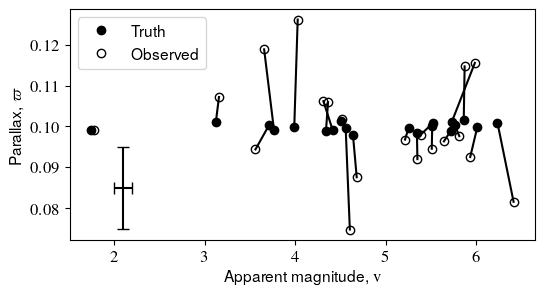

In [137]:
with plt.rc_context({"text.usetex": True}):
    fig, ax = plt.subplots(figsize=(6, 3))

    ax.plot(mag, par, "ok", label="Truth")
    ax.plot(mag_obs, par_obs, "ok", markerfacecolor="none", label="Observed")
    ax.plot(np.stack([mag, mag_obs]), np.stack([par, par_obs]), "k")
    ax.errorbar(2.1, 0.085, xerr=sigma_mag, yerr=sigma_par, color="k", capsize=4)

    ax.set_xlabel(r"Apparent magnitude, $\mathrm{v}$")
    ax.set_ylabel(r"Parallax, $\varpi$")
    ax.legend(loc="upper left")

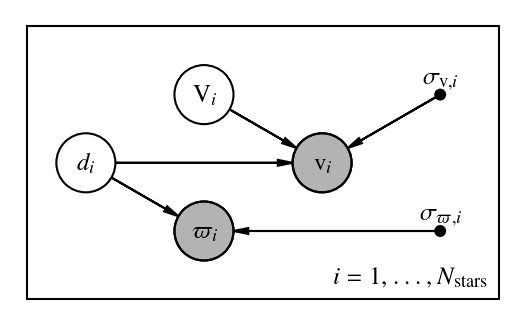

In [ ]:
ux = 1
uy = 1 / np.sqrt(3)
plot_params = {"facecolor": "white"}

with plt.rc_context({
    "font.size": 12,
    "text.usetex": True,
}):
    # Instantiate the PGM.
    pgm = daft.PGM()

    # Parameters
    pgm.add_node("d", r"$d_i$", 0, 0, plot_params=plot_params)
    pgm.add_node("abs_mag", r"$\mathrm{V}_i$", ux, uy, plot_params=plot_params)
    pgm.add_node("mag", r"$\mathrm{v}_i$", 2*ux, 0, observed=True)
    pgm.add_node("par", r"$\varpi_i$", ux, -uy, observed=True)

    # Uncertainties
    pgm.add_node("sigma_mag", r"$\sigma_{\mathrm{v},i}$", 3*ux, uy, fixed=True)
    pgm.add_node("sigma_par", r"$\sigma_{\varpi,i}$", 3*ux, -uy, fixed=True)

    pgm.add_edge("d", "mag")
    pgm.add_edge("d", "par")
    pgm.add_edge("abs_mag", "mag")
    pgm.add_edge("sigma_mag", "mag")
    pgm.add_edge("sigma_par", "par")

    pgm.add_plate([-ux/2, -2*uy, 4*ux, 4*uy], label=r"$i=1,\dots,N_\mathrm{stars}$", position='bottom right')

    # px = 4*ux
    # dx = 4.3*ux
    # pgm.add_text(px, 1.4*uy, pgm._nodes["d"].content)
    # pgm.add_text(dx, 1.4*uy, r"$\sim \mathcal{U}\,(0, 20)$")
    # pgm.add_text(px, 0.4*uy, pgm._nodes["abs_mag"].content)
    # pgm.add_text(dx, 0.4*uy, r"$\sim \mathcal{N}\,(0, 100)$")
    # pgm.add_text(px, -0.6*uy, pgm._nodes["par"].content)
    # pgm.add_text(dx, -0.6*uy, r"$\sim \mathcal{N}\,(d_i^{-1}, \sigma_{\varpi,i}^2)$")
    # pgm.add_text(px, -1.6*uy, pgm._nodes["mag"].content)
    # pgm.add_text(dx, -1.6*uy, r"$\sim \mathcal{N}\,(\mathrm{V}_i + 5\log_{10}d_i, \sigma_{\mathrm{v},i}^2)$")

    pgm.render(dpi=150)
    pgm.savefig("../figures/simple-pgm.pdf", format="pdf", dpi=300)

In [138]:
def simple_model(par_obs=None, mag_obs=None):
    d = numpyro.sample("d", dist.Uniform(0., 20.), sample_shape=shape)
    abs_mag = numpyro.sample("abs_mag", dist.Normal(0., 10.), sample_shape=shape)
    
    par = numpyro.deterministic("par", 1/d)
    mag = numpyro.deterministic("mag", abs_mag + 5.0 * jnp.log10(d))
    
    numpyro.sample("par_obs", dist.Normal(par, sigma_par), obs=par_obs)
    numpyro.sample("mag_obs", dist.Normal(mag, sigma_mag), obs=mag_obs)

In [139]:
sampler = NUTS(simple_model)
mcmc = MCMC(sampler, num_warmup=500, num_samples=1000, num_chains=10)

In [140]:
rng, key = random.split(rng)
mcmc.run(key, par_obs=par_obs, mag_obs=mag_obs)

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

In [141]:
mcmc.print_summary()


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
 abs_mag[0]     -1.63      0.27     -1.62     -2.06     -1.18   9922.83      1.00
 abs_mag[1]      0.10      0.27      0.12     -0.32      0.55  10853.91      1.00
 abs_mag[2]     -0.56      0.23     -0.56     -0.94     -0.18  11280.17      1.00
 abs_mag[3]      1.26      0.22      1.27      0.90      1.63  10622.44      1.00
 abs_mag[4]      0.50      0.26      0.51      0.07      0.94  10760.37      1.00
 abs_mag[5]      0.08      0.25      0.09     -0.33      0.50   9383.81      1.00
 abs_mag[6]      0.32      0.26      0.33     -0.12      0.74   8231.94      1.00
 abs_mag[7]     -3.29      0.25     -3.28     -3.69     -2.88  11251.20      1.00
 abs_mag[8]     -0.68      0.28     -0.67     -1.15     -0.22   9727.48      1.00
 abs_mag[9]     -0.50      0.24     -0.49     -0.90     -0.11  10645.08      1.00
abs_mag[10]     -0.50      0.20     -0.50     -0.83     -0.18  13004.77      1.00
abs_mag[11]    

In [142]:
coords = {"Star": np.arange(num_obs)}
dims = {
    "d": ["Star"], 
    "mag": ["Star"], 
    "abs_mag": ["Star"], 
    "par": ["Star"],
    "par_obs": ["Star"],
    "mag_obs": ["Star"]
}

samples_simple = mcmc.get_samples()
data_simple = az.from_numpyro(mcmc, coords=coords, dims=dims)
data_simple

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

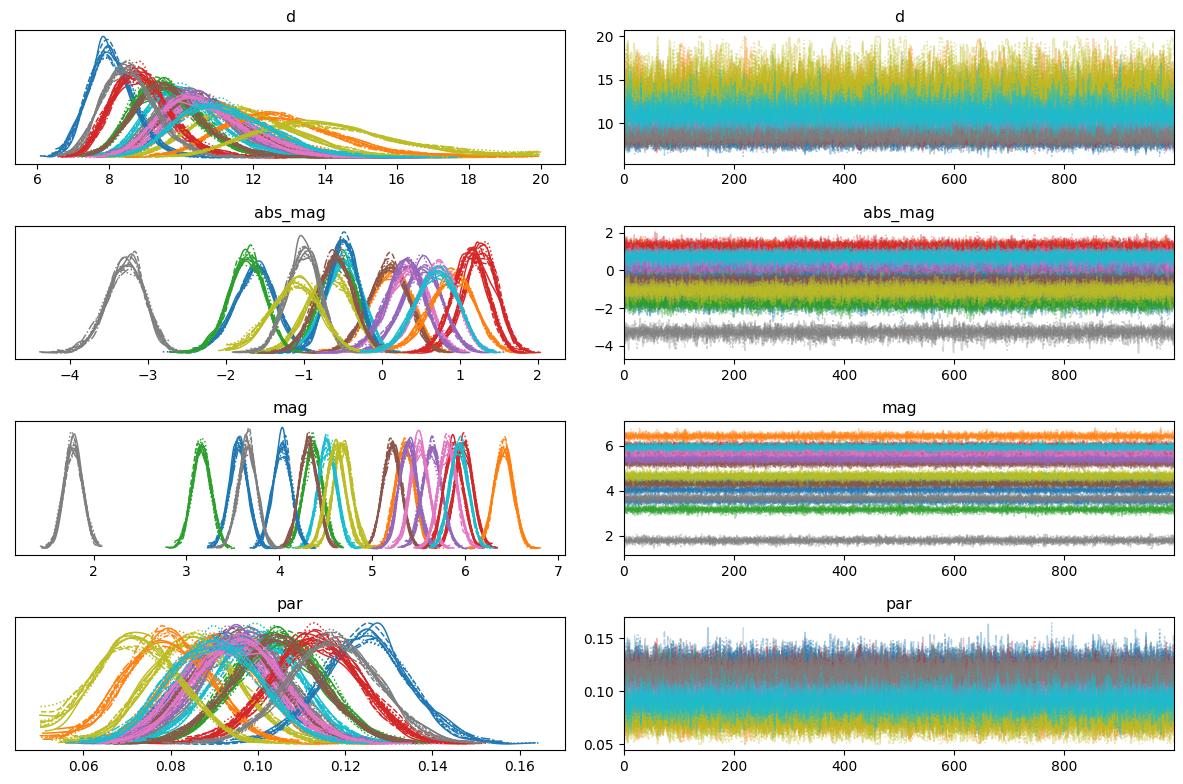

In [143]:
var_names = ["d", "abs_mag", "mag", "par"]
ax = az.plot_trace(data_simple, var_names=var_names)
plt.gcf().tight_layout()

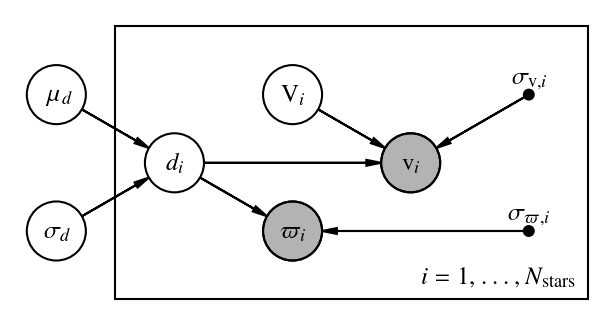

In [ ]:
# Instantiate the PGM.
with plt.rc_context({
    # "mathtext.fontset": "dejavuserif",
    "font.size": 12,
    "text.usetex": True,
}):
    pgm = daft.PGM()

    # Hyperparameters
    pgm.add_node("mu_d", r"$\mu_d$", -ux, uy, plot_params=plot_params)
    pgm.add_node("sigma_d", r"$\sigma_d$", -ux, -uy, plot_params=plot_params)

    # Parameters
    pgm.add_node("d", r"$d_i$", 0, 0, plot_params=plot_params)
    pgm.add_node("abs_mag", r"$\mathrm{V}_i$", 1, uy, plot_params=plot_params)
    pgm.add_node("mag", r"$\mathrm{v}_i$", 2*ux, 0, observed=True)
    pgm.add_node("par", r"$\varpi_i$", ux, -uy, observed=True)

    # Uncertainties
    pgm.add_node("sigma_mag", r"$\sigma_{\mathrm{v},i}$", 3*ux, uy, fixed=True)
    pgm.add_node("sigma_par", r"$\sigma_{\varpi,i}$", 3*ux, -uy, fixed=True)


    pgm.add_edge("mu_d", "d")
    pgm.add_edge("sigma_d", "d")

    pgm.add_edge("d", "mag")
    pgm.add_edge("d", "par")
    pgm.add_edge("abs_mag", "mag")
    pgm.add_edge("sigma_mag", "mag")
    pgm.add_edge("sigma_par", "par")

    pgm.add_plate([-ux/2, -2*uy, 4*ux, 4*uy], label=r"$i=1,\dots,N_\mathrm{stars}$", position='bottom right')
    
    # px = 4*ux
    # dx = 4.5*ux
    # pgm.add_text(px, 0.9*uy, pgm._nodes["mu_d"].content)
    # pgm.add_text(dx, 0.9*uy, r"$\sim \mathcal{U}\,(0, 20)$")

    # pgm.add_text(px, -0.1, r"$\ln\,$"+pgm._nodes["sigma_d"].content)
    # pgm.add_text(dx, -0.1, r"$\sim \mathcal{N}\,(-\ln(10), 1)$")

    # pgm.add_text(px, -1.1*uy, pgm._nodes["d"].content)
    # pgm.add_text(dx, -1.1*uy, r"$\sim \mathcal{N}(\mu_d, \sigma_d^2)$")

    pgm.render(dpi=150)
    pgm.savefig("../figures/hbm-pgm.pdf", format="pdf", dpi=300)

In [144]:
def hierarchical_model(par_obs=None, mag_obs=None):
    mu_d = numpyro.sample("mu_d", dist.Uniform(0., 20.))
    sigma_d = numpyro.sample("sigma_d", dist.LogNormal(jnp.log(0.1), 1.0))
    # sigma_d = numpyro.deterministic("sigma_d", jnp.exp(log_sigma_d))
    _d = numpyro.sample("_d", dist.Normal(), sample_shape=shape)
    d = numpyro.deterministic("d", mu_d + sigma_d * _d)
    
    abs_mag = numpyro.sample("abs_mag", dist.Normal(0., 10.), sample_shape=shape)
    
    par = numpyro.deterministic("par", 1/d)
    mag = numpyro.deterministic("mag", abs_mag + 5.0 * jnp.log10(d))
    
    numpyro.sample("par_obs", dist.Normal(par, sigma_par), obs=par_obs)
    numpyro.sample("mag_obs", dist.Normal(mag, sigma_mag), obs=mag_obs)

In [145]:
sampler = NUTS(hierarchical_model, target_accept_prob=0.98)
mcmc = MCMC(sampler, num_warmup=500, num_samples=1000, num_chains=10)

In [146]:
rng, key = random.split(rng)
mcmc.run(key, par_obs=par_obs, mag_obs=mag_obs)

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

In [147]:
mcmc.print_summary()


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      _d[0]      0.11      0.98      0.11     -1.52      1.71  10000.78      1.00
      _d[1]      0.14      0.98      0.15     -1.48      1.71  11012.69      1.00
      _d[2]     -0.11      0.97     -0.11     -1.71      1.47   9764.30      1.00
      _d[3]     -0.28      0.99     -0.30     -1.92      1.33   8296.46      1.00
      _d[4]      0.08      0.98      0.09     -1.51      1.71  11138.74      1.00
      _d[5]      0.07      0.98      0.09     -1.53      1.64  11312.05      1.00
      _d[6]      0.09      0.98      0.09     -1.47      1.73  10438.25      1.00
      _d[7]      0.02      0.97     -0.00     -1.59      1.64  10942.38      1.00
      _d[8]      0.22      0.98      0.23     -1.40      1.80  10085.33      1.00
      _d[9]     -0.02      0.95     -0.02     -1.50      1.62  10873.09      1.00
     _d[10]     -0.48      1.05     -0.48     -2.20      1.23   4572.96      1.00
     _d[11]    

In [148]:
dims["_d"] = ["Star"]

samples_hbm = mcmc.get_samples()
data_hbm = az.from_numpyro(mcmc, coords=coords, dims=dims)
data_hbm

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

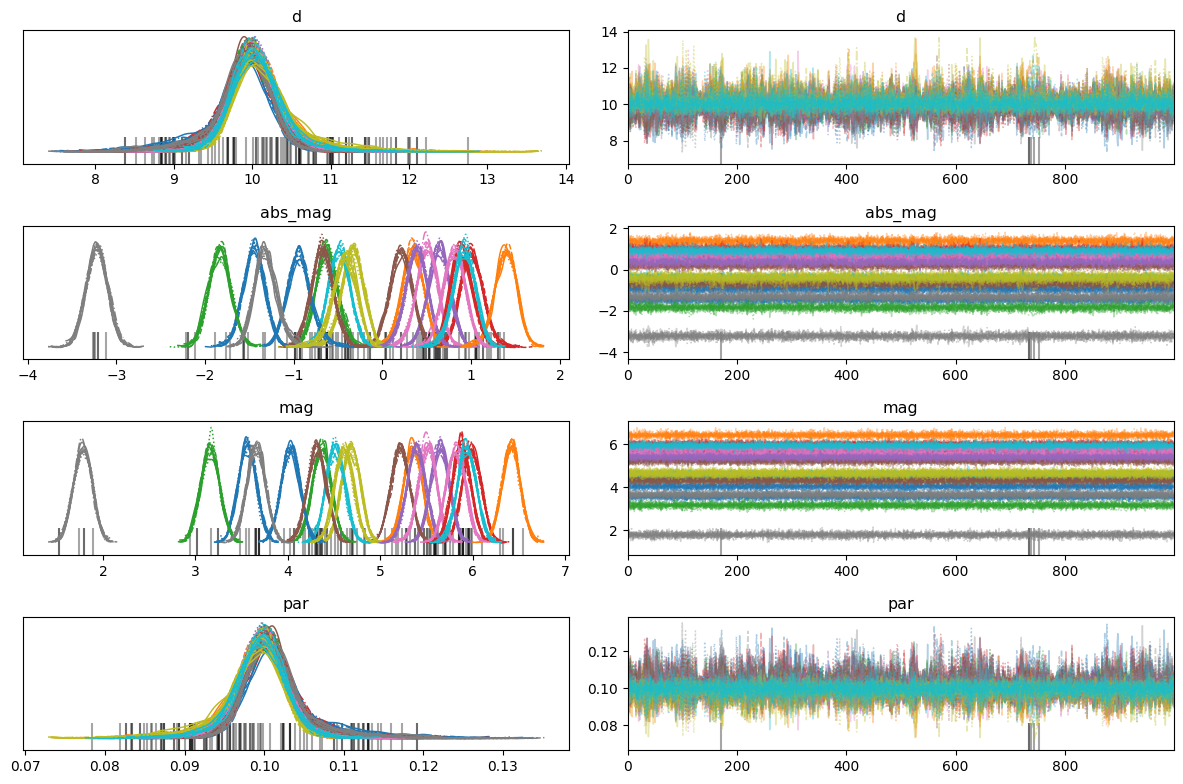

In [149]:
ax = az.plot_trace(data_hbm, var_names=var_names)
plt.gcf().tight_layout()

In [150]:
data_simple.to_netcdf("data/hbm-simple.nc")
data_hbm.to_netcdf("data/hbm-hierarchical.nc")

'data/hbm-hierarchical.nc'